In [1]:
import pandas as pd
import numpy as np 

w_11_data = pd.read_table('w11-data.tbl',delim_whitespace=True)

## 1. Reproduce Watsons's K-means result

In [2]:
import scipy
from scipy import spatial
class hard_KMeans():

    def __init__ (self, seed, k, N, G,features):
        """
        Initializing class variables
        """
        self.seed = seed
        self.k = k # number of clusters
        self.N = N # number of cells
        self.G = G # number of features/genes
        self.features = features
        self.features_df = pd.DataFrame(features)
        self.tsd = 0  # initializing total - squared distance
        self.centroid = np.zeros((self.k,self.G)) # initializing a mu matrix

  

    def centroid_initialization(self):

        """
        This function first finds the max and min for each feature in the feautre set,
        and then randomly selects k numbers for each feature. It returns a k x G 2-dimensional numpy array.
        For example, a feature set with 2 genes and 5 clusters (k) will return a 5 by 2 numpy array.
        """

        np.random.seed(self.seed)
        max_min_for_each_dim = [(max(self.features[:,dim]),min(self.features[:,dim])) for dim in self.features_df]
        start_centroid = np.zeros((self.G,self.k))
        for dim,max_min_tuple in enumerate(max_min_for_each_dim):
            start_centroid[dim] = np.random.uniform(low = max_min_tuple[1], high = max_min_tuple[0],size = self.k)
        self.centroid = start_centroid.T
    

        return self.centroid


    def assign_clusters(self):

        """
        The functions takes in centroid and features matrix and computes the euclidean distance matrix
        between each feature vector and each centroid. Each cell is then assigned to its nearest centroid based
        on the distances computed in the distance matrix.
        """
        
        distance_matrix = spatial.distance_matrix(self.features,self.centroid) # Note: Sean said scipy is allowed
        self.features_df['cluster'] = [np.argmin(cell) for cell in distance_matrix]

        return self.features_df

    def total_squared_distance(self,new_centroids):

        """
        Given the features with clusters already assigned to them, this function calculates the total squared
        distance of every cell to its assigned centroid. There is one for loop that loops through all the clusters, 
        and computations over G and N are vectorized.
        """
        
        temp_tsd = 0

        for k in range(0,self.k):
            temp_df = self.features_df.query("cluster == @k")
            temp_tsd = temp_tsd + np.sum((temp_df.iloc[:,0:self.G].to_numpy() - new_centroids[k-1]) ** 2)

        return temp_tsd
    
    def update_centroid(self):

        """
        This function calculates new centroids based on features with given cluster assignments.
        There is one for loop that loops through all the clusters, and computations over G and N are vectorized.
        """

        new_centroid = np.zeros((self.k,self.G))
     
        for k in range(0,self.k):
            temp_df = self.features_df.query("cluster == @k")

            if temp_df.shape[0] != 0:
                new_centroid[k-1] = (temp_df.iloc[:,0:self.G].sum(axis = 0) / temp_df.shape[0]).to_numpy()
            else:
                continue
                    
        temp_tsd = np.round(self.total_squared_distance(new_centroid),decimals = 0)
     
        
        status = 'go'
        if temp_tsd < self.tsd:
            self.tsd = temp_tsd
            self.centroid = new_centroid
            status = 'go'
        elif temp_tsd >= self.tsd :
            status = 'converged'

        return status

    def train(self):


        """
        This function "trains" the hard k-means model by first initalizing the centroids
        and then iterating through the following steps until convergence:

        1. Assignment step: Assign each data point X_i to its closest centroid μ_k.

        2. Update step: Calculate new centroids μ_k.

        The function is ran on 10 different seeds
        """
        train_status = 'go'
        initial_centroids = self.centroid_initialization()
        training_cycle = 0
        while train_status != 'converged':
    
            self.assign_clusters()
            if training_cycle == 0:
                self.tsd = np.round(self.total_squared_distance(self.centroid),decimals = 0)
            train_status = self.update_centroid()
            training_cycle += 1 
        self.assign_clusters()
        
        
        return self.centroid, self.features_df['cluster'].to_numpy(), self.tsd




In [3]:
tot_sqdist_list = []
centroids_list = []
clusters_list = []
np.random.seed(42)
for seed in np.random.randint(0,10000,size = 40):
    hard_kmeans = hard_KMeans(seed = seed,k = 8, N = 200, G = 2001 , features = np.log(w_11_data.to_numpy()))
    centroids, clusters, tot_sqdist = hard_kmeans.train()
    tot_sqdist_list.append(tot_sqdist)
    centroids_list.append(centroids)
    clusters_list.append(clusters)
best_run = np.argmin(tot_sqdist_list)
print('Best Sum of the Squared Distance')
print(tot_sqdist_list[best_run])




Best Sum of the Squared Distance
87708.0


### My sum of squared distance of 87708 is close to Watson's sum of squared distance of 87378.2.

## 2. Reduce the dimensionality

In [154]:
center_function = lambda x: x - x.mean()

def pca(x):
  x = np.log(x)
  n, m = x.shape
  x_centered = x.apply(center_function,axis=0)
  # Compute full SVD
  U, S, W_t = np.linalg.svd(x_centered,full_matrices=False)
  eigen_values = np.square(S) / (n-1)
  return U,S,W_t.T, eigen_values, x_centered

In [155]:
U,S, W, eigen_values,x_centered = pca(w_11_data)
# Sort eigen values and eigen vectors in descending order
eigen_values = eigen_values[np.argsort(eigen_values)[::-1]]
W = W[:,np.argsort(eigen_values)[::-1]]


pc_scores = x_centered@W
pc_scores['clusters'] = clusters


Text(0, 0.5, 'PC2')

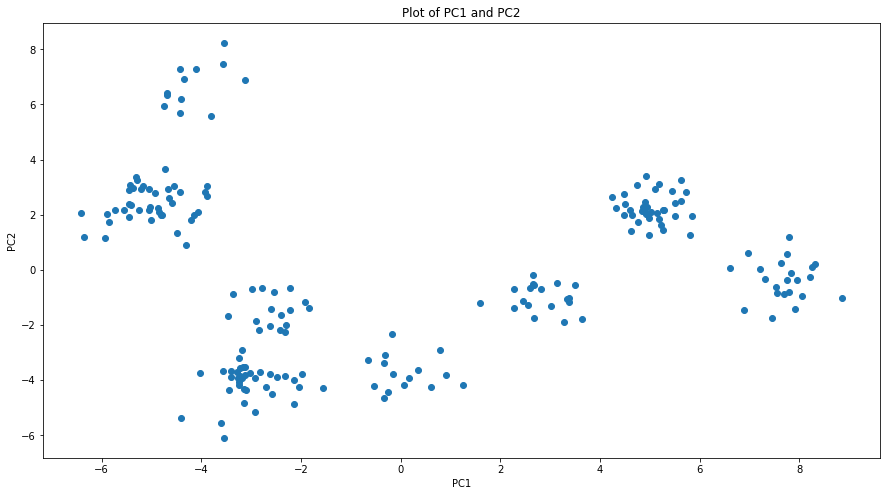

In [113]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
plt.figure(figsize = (15,8))
plt.title('Plot of PC1 and PC2')
plt.scatter(pc_scores.iloc[:,0],pc_scores.iloc[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')



### Based on the above plot of the first two principal component scores colored by the 8 clusters assigned via K-Means, I observe 8 clusters but the assignments differ from the k-means cluster assignments.

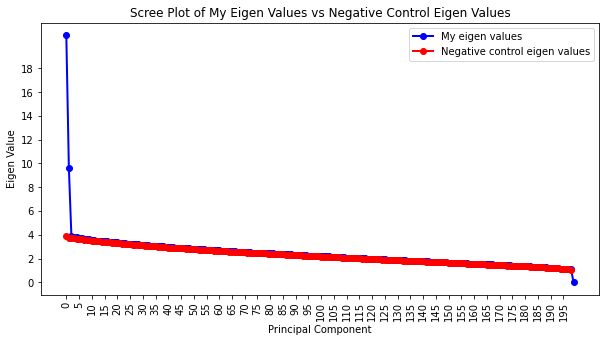

In [247]:
negative_control_eigen = pd.read_table('w11-eigen.tbl',delim_whitespace=True, header= None)
plt.figure(figsize=(10,5))
plt.plot(list(range(0,len(eigen_values))), eigen_values, 'o-', linewidth=2, color='blue',label = 'My eigen values')
plt.plot(list(range(0,negative_control_eigen.shape[0])), negative_control_eigen.iloc[:,1], 'o-', linewidth=2, color='red',label = 'Negative control eigen values')
plt.title('Scree Plot of My Eigen Values vs Negative Control Eigen Values')
plt.xlabel('Principal Component')
plt.ylabel('Eigen Value')
plt.xticks(np.arange(0,200, step=5),rotation=90)
plt.yticks(np.arange(0,20, step=2))
plt.legend()
plt.show()

### Comparing the scree plot of eigen values I am investigating versus the scree plot of the eigen values from negative control, I think it would be hard to find any other clusters in the dataset because the eigen values drop drastically after the second principal component. Also, only eigen values from PC1 and PC2 are above the negative control PCs.

### To investigate how many genes appear to influence cell type identity, we need to look at the loadings for each gene in PC1 and PC2 which explains the most variance. Plotting PC1 against PC2:

Text(0.5, 1.0, 'PC1 vs PC2')

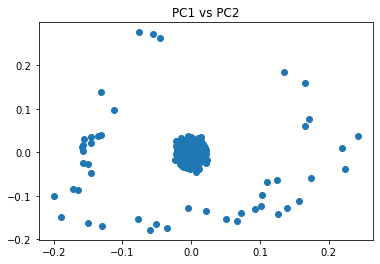

In [89]:
plt.scatter(W[:,0],W[:,1])
plt.title('PC1 vs PC2')

In [126]:
df = pd.DataFrame(W[:,:2],columns=['pc1','pc2'])
conditions = [(df['pc1'] < 0.05) & (df['pc1'] > -0.05) & (df['pc2'] < 0.05) & (df['pc2'] > -0.05)]
choices = [0]
df['influential'] = np.select(conditions, choices, default=1)
df['influential'].value_counts()

0    1954
1      47
Name: influential, dtype: int64

### The genes that are centered around zero are not doing much. Thus, we only need to count the genes that are not part of the cluster centered at zero. If I set an arbitrary thershold of ( -0.05 < PC1 < 0.05 ) and ( -0.05 < PC2 < 0.05 ) as non-influential and count the total number of genes that do not statisfy this condition, then I count 47 influential genes.

## 3. Check the K

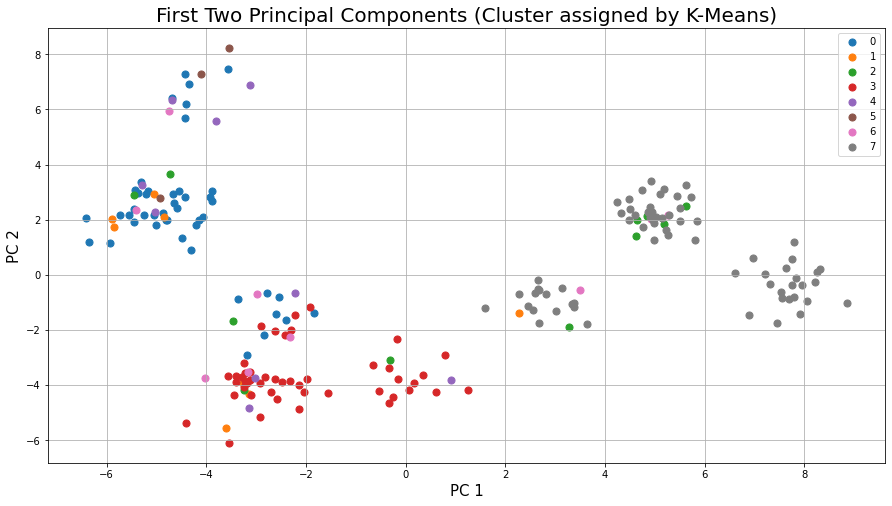

In [109]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('First Two Principal Components (Cluster assigned by K-Means)', fontsize = 20)
targets = [0,1,2,3,4,5,6,7]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
for target, color in zip(targets,colors):
    indicesToKeep = pc_scores['clusters'] == target
    ax.scatter(pc_scores.loc[indicesToKeep, 0]
               , pc_scores.loc[indicesToKeep,1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### K-means clustering assignments are off. We saw that only 47 genes/dimensions are contributing to cell type identity. However, K-Means is not a dimensionalty reduction method and it took all 2001 genes/dimensions into account when it calculates the total-squared distances. Thus, K-Means included a lot of noise in it's total-squared distance calculation. However, in PCA, we are able to only use the first two principal components scores that explains the most variance to visualize the data so we can more easily see potential clusters.

### I can fix K-Means by clustering on PC1 scores and PC2 scores.

In [150]:
tot_sqdist_list = []
centroids_list = []
clusters_list = []
np.random.seed(42)
for seed in np.random.randint(0,10000,size = 40):
    hard_kmeans = hard_KMeans(seed = seed,k = 8, N = 200, G = 2 , features = pc_scores.iloc[:,:2].to_numpy())
    centroids, clusters, tot_sqdist = hard_kmeans.train()
    tot_sqdist_list.append(tot_sqdist)
    centroids_list.append(centroids)
    clusters_list.append(clusters)
best_run = np.argmin(tot_sqdist_list)
print('Best Sum of the Squared Distance')
print(tot_sqdist_list[best_run])


Best Sum of the Squared Distance
131.0


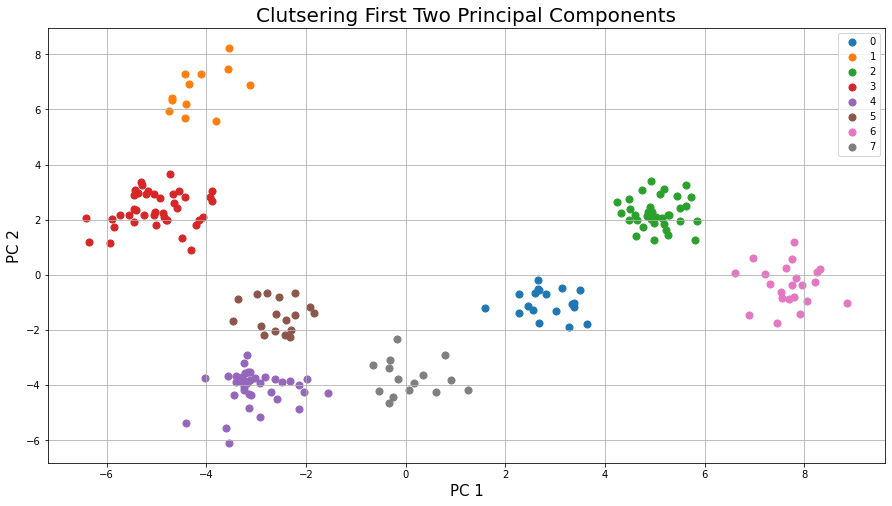

In [151]:
pc_scores['new_clusters'] = clusters_list[best_run]
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('Clutsering First Two Principal Components', fontsize = 20)
targets = [0,1,2,3,4,5,6,7]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
for target, color in zip(targets,colors):
    indicesToKeep = pc_scores['new_clusters'] == target
    ax.scatter(pc_scores.loc[indicesToKeep, 0]
               , pc_scores.loc[indicesToKeep,1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

## 4. reconstruct the expression patterns

### I will denoise the data by applying the following formula $X^*_q=U_qS_qW^⊤_q$ to get my denoised $X$

In [197]:
X_new = U[:,:2] @ np.diag(S[:2]) @ W[:,:2].T

In [245]:
import seaborn as sns
def plot_data_heatmap(X):
    '''
    Plot a heatmap of the data X.
    
    Input:
        X   Numpy array data matrix, where rows are observations, and columns are variables.
    '''
    max_intensity, min_intensity = np.max(X), np.min(X)

    plt.figure(figsize=(10,6))
    sns.heatmap(X, 
                cmap='Greys', vmin=min_intensity, vmax=max_intensity, 
                cbar_kws={'label': 'intensity', 'shrink': 0.75})
    plt.xlabel('Gene'); plt.ylabel('Cell')
    plt.show()

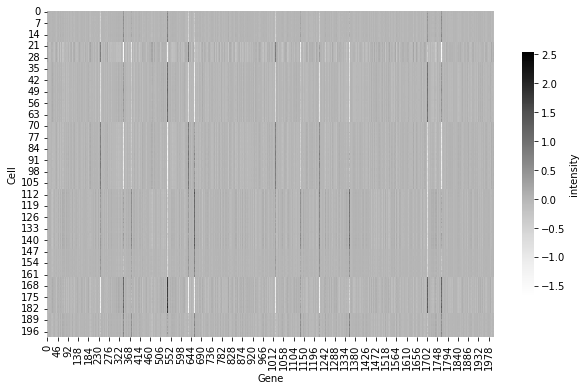

In [246]:
plot_data_heatmap(X_new.sort_values('clusters')[X_new.columns[0:2001]].to_numpy())

### The clusters in the heatmap now look more obvious compared to  Wiggins' heatmap. This is because the data used to plot the heatmap is denoised data.